### DATA103 Final Project <br>
Submitted by **ALDECOA**, Renzel; **LLANES**, Arlan; **OPALLA**, Rijan - S11

---
#### Statment of the Problem

The <a href="https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset">USA Real Estate Dataset</a> offers listings of property sold in the USA across multiple states. According to the author, the data was collected from <a href="https://www.realtor.com/">realtor.com</a>, a real estate listing website managed by *Move, Inc.*, a company based in Santa Clara, California.

The dataset contains **2,226,382** property listings with **10** features. These features are the following:
- ```brokered by``` - an encoded identification number for an agency/broker
- ```status``` - housing status; can be (a) ready for sale, (b) sold, or (c) ready to build
- ```price``` - housing price; either current listing price or recently sold price
- ```bed``` - number of beds in the property
- ```bath``` - number of bathrooms in the property
- ```acre_lot``` - total property/lot area, in acres
- ```street``` - encoded street address
- ```city``` - city where the property is located
- ```state``` - state where the property is located
- ```zip_code``` - postal code of the area
- ```house_size``` - the size of the property, in square feet; and
- ```prev_sold_date``` - previous date of sale

This will be a **classification** problem. The project is concerned with identifying which properties for sale are **worth the price**, using the features available in the dataset. These features will be the following:

Main features:
- ```price```
- ```bed``` (number of bedrooms)
- ```bath``` (number of bathrooms)
- ```acre_lot``` (area of lot in acres)
- ```house_size``` (size of house in square feet)

Label:
- ```Worth [1]``` / ```Not worth [0]``` (binary) - determines if the house, with its amenities, is worth the price


---
#### Importing necessary libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

---
#### Extracting dataset from compressed file

The dataset itself is **large**, amounting to **178.86** MB of space. The dataset is pushed into the repository in a compressed state, as to not require the use of *Git LFS* (Large File Storage) 

In [10]:
import zipfile
with zipfile.ZipFile('USA-Real-Estate/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('USA-Real-Estate/')

In [11]:
df = pd.read_csv("USA-Real-Estate/realtor-data.zip.csv", low_memory=False)
df.shape

(2226382, 12)

---
#### Exploring the dataset

In [13]:
df.head(3)

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN


The features include the following:

In [15]:
df.columns

Index(['brokered_by', 'status', 'price', 'bed', 'bath', 'acre_lot', 'street',
       'city', 'state', 'zip_code', 'house_size', 'prev_sold_date'],
      dtype='object')

In [16]:
df.dtypes

brokered_by       float64
status             object
price             float64
bed               float64
bath              float64
acre_lot          float64
street            float64
city               object
state              object
zip_code          float64
house_size        float64
prev_sold_date     object
dtype: object

Brief statistical description of ```float``` type features (that are **not** numbers used for categorical encoding):

In [18]:
df_desc = df[["price", "bed", "bath", "acre_lot", "house_size"]].describe().T
df_desc

,count,mean,std,min,25%,50%,75%,max
price,2224841.0,524195.519291,2.138893e+06,0.0,165000.00,325000.00,550000.00,2.147484e+09
bed,1745065.0,3.275841,1.567274e+00,1.0,3.00,3.00,4.00,4.730000e+02
bath,1714611.0,2.496440,1.652573e+00,1.0,2.00,2.00,3.00,8.300000e+02
acre_lot,1900793.0,15.223027,7.628238e+02,0.0,0.15,0.26,0.98,1.000000e+05
house_size,1657898.0,2714.471335,8.081635e+05,4.0,1300.00,1760.00,2413.00,1.040400e+09


The standard deviation of ```price``` is uncommonly large. <br>
There may be outliers under this feature. To check, we count how many records are below and above the average.

In [20]:
below_mean = df.loc[df["price"] <= df_desc.at["price", "mean"]]
above_mean = df.loc[df["price"] > df_desc.at["price", "mean"]]

In [21]:
below_mean_ratio = round((below_mean.shape[0] / df.shape[0]) * 100, 4)
above_mean_ratio = round((above_mean.shape[0] / df.shape[0]) * 100, 4)

print(f"Records below mean price: {below_mean.shape[0]} ({below_mean_ratio}%)")
print(f"Records above mean price: {above_mean.shape[0]} ({above_mean_ratio}%)")

Records below mean price: 1618875 (72.7133%)
Records above mean price: 605966 (27.2175%)


Not an even split, as seen in the ratios. <br>
Let's check the distribution of records below and above the mean ```price```.

In [23]:
below_mean_desc = below_mean[["price", "bed", "bath", "acre_lot", "house_size"]].describe().T
below_mean_desc

,count,mean,std,min,25%,50%,75%,max
price,1618875.0,240941.372498,142964.836344,0.0,120000.00,239900.00,354900.00,5.241900e+05
bed,1196453.0,3.054735,1.256840,1.0,2.00,3.00,4.00,4.730000e+02
bath,1175458.0,2.156122,1.235881,1.0,2.00,2.00,3.00,7.520000e+02
acre_lot,1384297.0,12.533855,764.802540,0.0,0.16,0.26,0.92,1.000000e+05
house_size,1135318.0,2646.508983,976442.545012,100.0,1202.00,1576.00,2042.00,1.040400e+09


In [24]:
above_mean_desc = above_mean[["price", "bed", "bath", "acre_lot", "house_size"]].describe().T
above_mean_desc

,count,mean,std,min,25%,50%,75%,max
price,605966.0,1.280926e+06,3.994411e+06,524200.0,625000.00,796713.00,1225000.00,2.147484e+09
bed,547527.0,3.758900e+00,2.008743e+00,1.0,3.00,4.00,4.00,2.220000e+02
bath,538391.0,3.240023e+00,2.134310e+00,1.0,2.00,3.00,4.00,8.300000e+02
acre_lot,515404.0,2.241875e+01,7.580962e+02,0.0,0.15,0.26,1.06,1.000000e+05
house_size,521649.0,2.863748e+03,2.636842e+04,4.0,1734.00,2422.00,3312.00,1.299220e+07


(array([6.05959e+05, 3.00000e+00, 1.00000e+00, 0.00000e+00, 2.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([5.24200000e+05, 2.15220140e+08, 4.29916080e+08, 6.44612020e+08,
        8.59307960e+08, 1.07400390e+09, 1.28869984e+09, 1.50339578e+09,
        1.71809172e+09, 1.93278766e+09, 2.14748360e+09]),
 <BarContainer object of 10 artists>)

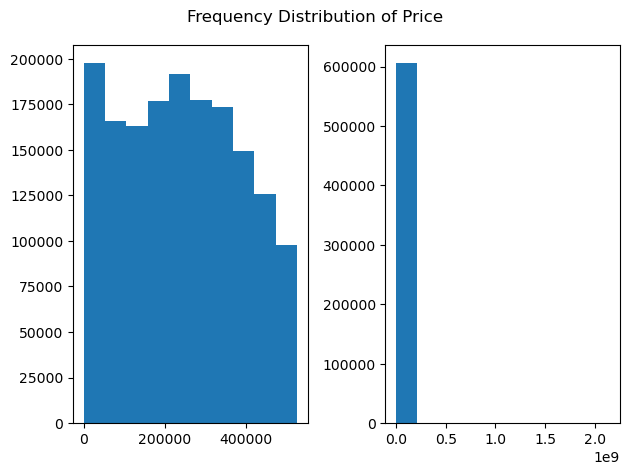

In [25]:
fig, axs = plt.subplots(1, 2, tight_layout=True)
fig.suptitle("Frequency Distribution of Price")

axs[0].hist(below_mean["price"])
axs[1].hist(above_mean["price"])